In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import random
import glob
import cv2
import albumentations as A
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import  ImageDataGenerator
from keras.layers import Dense,Flatten,BatchNormalization,MaxPooling2D,Conv2D,Input
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras import Model
from sklearn.metrics import classification_report , confusion_matrix

In [3]:
normal_jpg = glob.glob( r"D:\data sci sem\covid\Covid\Covid\X-ray\Healthy\*.jpg")
covid_jpg = glob.glob(r"D:\data sci sem\covid\Covid\Covid\X-ray\Disease\*.jpg")

normal_jpeg = glob.glob( r"D:\data sci sem\covid\Covid\Covid\X-ray\Healthy\*.jpeg")
covid_jpeg = glob.glob( r"D:\data sci sem\covid\Covid\Covid\X-ray\Disease\*.jpeg")

normal_png = glob.glob( r"D:\data sci sem\covid\Covid\Covid\X-ray\Healthy\*.png")
covid_png = glob.glob( r"D:\data sci sem\covid\Covid\Covid\X-ray\Disease\*.png")

normal = normal_jpg + normal_jpeg + normal_png
covid = covid_jpg + covid_jpeg + covid_png

random.shuffle(normal)
random.shuffle(covid)

train_normal = normal [:int (len (normal) *0.8)]
test_normal = normal[int (len (normal) *0.8):]

train_covid = covid [:int (len (covid) *0.8)]
test_covid = covid[int (len (covid) *0.8):]

print ('number of train normal x-rays = {}'.format(len (train_normal)))
print ('number of train covid x-rays = {}'.format(len (train_covid)))

print ('------------------------------------')

print ('number of test normal x-rays = {}'.format(len (test_normal)))
print ('number of test covid x-rays = {}'.format(len (test_covid)))

number of train normal x-rays = 6398
number of train covid x-rays = 2264
------------------------------------
number of test normal x-rays = 1600
number of test covid x-rays = 566


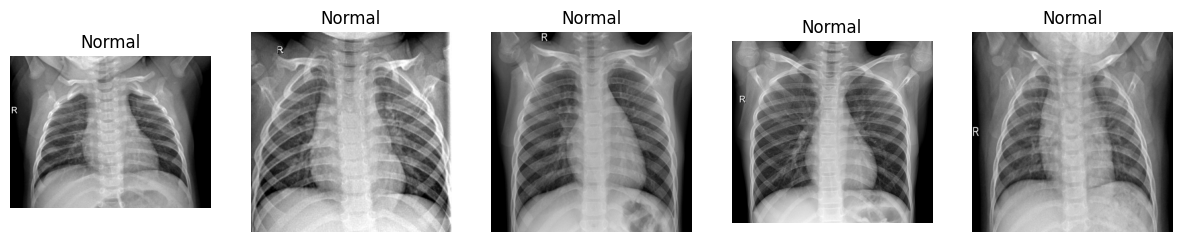

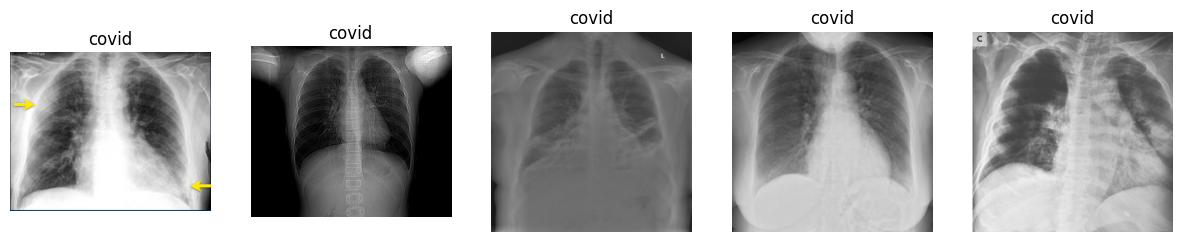

In [4]:
def plot_images (data ,image_title,num_of_images ,type_image = 'bgr'):
    plt.figure(figsize=(15,10))
    for i in range (num_of_images):
        random_image = random.choice(data)
        
        if type (data) == list:
            random_image = cv2.imread(random_image) 
            if len (random_image.shape) == 3:
                random_image =  cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)
            if len (random_image.shape) == 2:
                random_image =  cv2.cvtColor(random_image, cv2.COLOR_GRAY2RGB)
            
        plt.subplot(1,num_of_images,i+1)
        plt.imshow(random_image)
        plt.axis('off')
        plt.title (image_title)
    
    plt.show()

plot_images (train_normal ,'Normal',5)
plot_images (train_covid ,'covid',5)

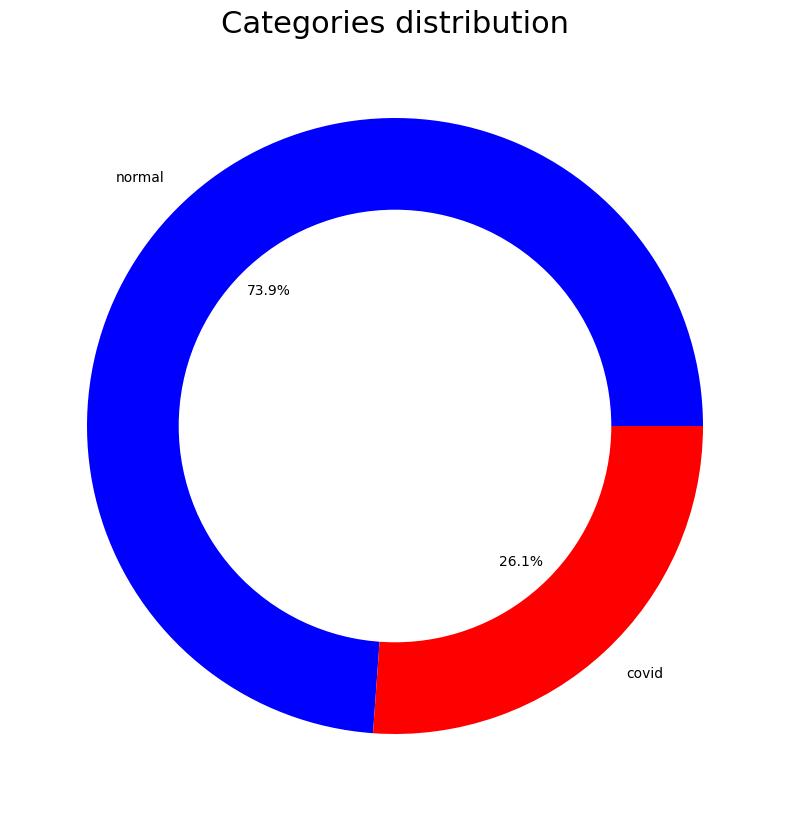

In [5]:
def plt_pie (data,labels,colors,title):
    plt.figure(figsize=(20,10))
    my_circle=plt.Circle( (0,0), 0.7, color='white')
    plt.pie(data,labels = labels, colors = colors , autopct='%1.1f%%')
    p=plt.gcf()
    p.gca().add_artist(my_circle)
    plt.title (title,fontsize = 22)
    plt.show()
    
data = [len (train_normal) , len (train_covid) ]
labels = ['normal' , 'covid' ]
colors = ['blue','red']
plt_pie (data,labels,colors , 'Categories distribution')

In [6]:
def image_augmentation(low_data,target , p=0.5):
    
    images =[]
    
    albumentation_list = [A.RandomBrightnessContrast(p = 0.5),A.RGBShift(p=p) ,
                          A.Rotate(p=p, limit=40) , A.RandomCrop(p=p,height = 120, width = 120)]
    
    while (len (images) < target):
        for image in low_data:
            img = cv2.resize(cv2.imread(image), (150, 150) )
            if len (img.shape) == 2:
                img =  cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            operation = random.choice(albumentation_list)
            img = operation (image = img)['image']
            
            if img.shape[0] !=150:
                img = cv2.resize (img , (150, 150))
    
            images.append (img)
        
            if (len (images) >= target):
                break
    return np.array (images)

In [7]:
def convert_links_to_images(data):
    images =[]
    for image in data:
        img = cv2.resize(cv2.imread(image), (150, 150) )
        if len (img.shape) == 2:
                img =  cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        images.append(img)
    return np.array (images)

In [8]:
train_normal_images = image_augmentation(train_normal,8000,p=1)
train_covid_images = image_augmentation(train_covid,8000,p=1)

test_normal_images = convert_links_to_images(test_normal)
test_covid_images = convert_links_to_images(test_covid)

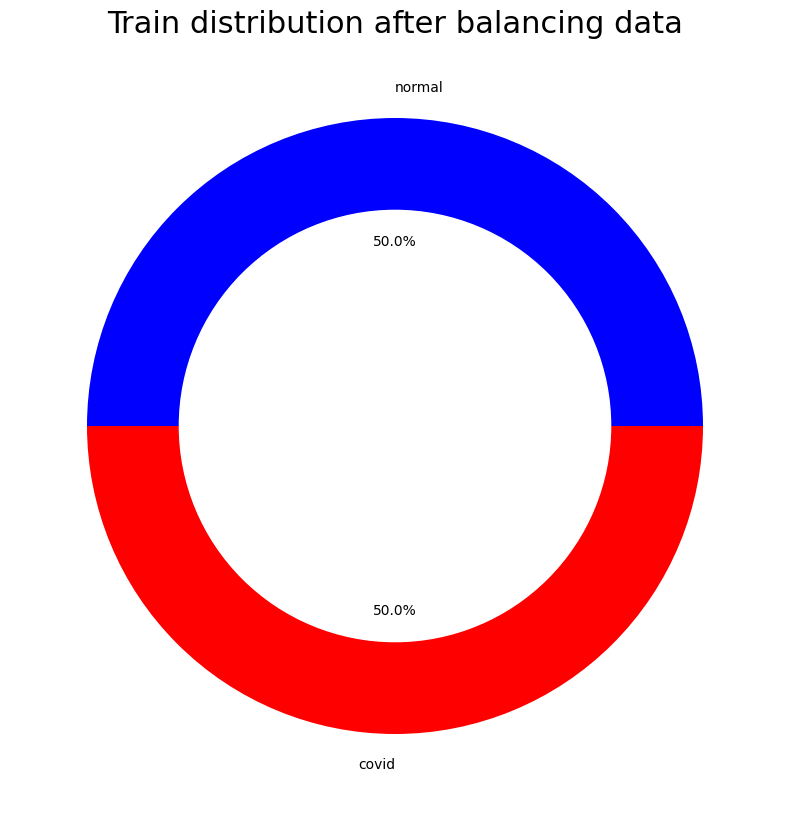

In [9]:
plt_pie ([len (train_normal_images) ,len (train_covid_images)] ,labels,colors,'Train distribution after balancing data')

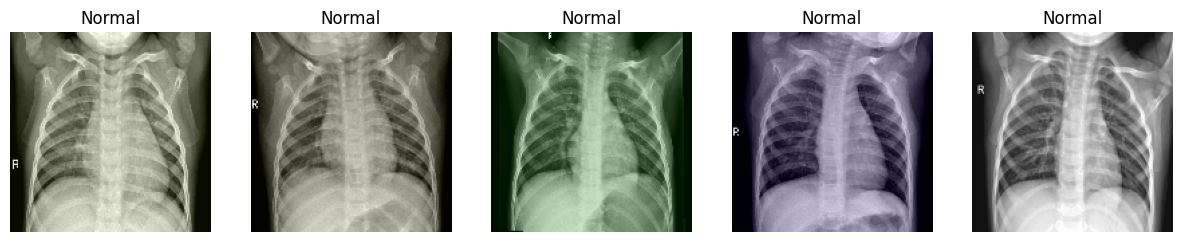

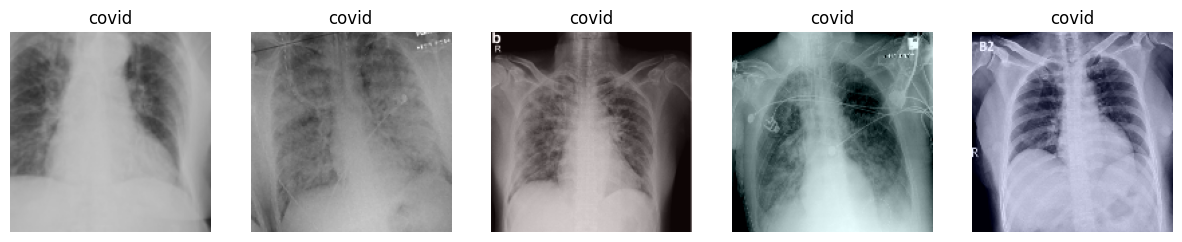

In [10]:
#Train data
plot_images (train_normal_images ,'Normal',5)
plot_images (train_covid_images ,'covid',5)


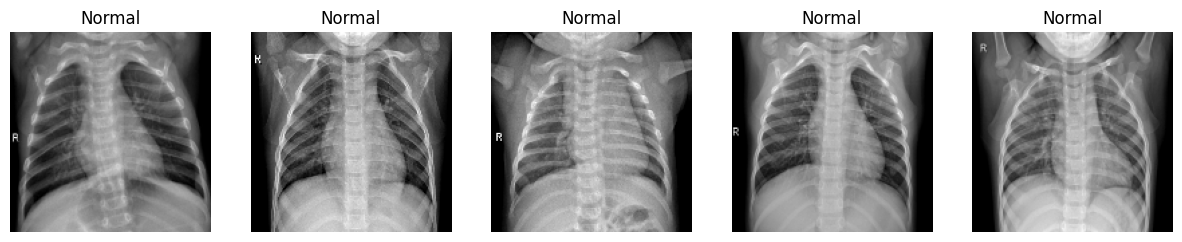

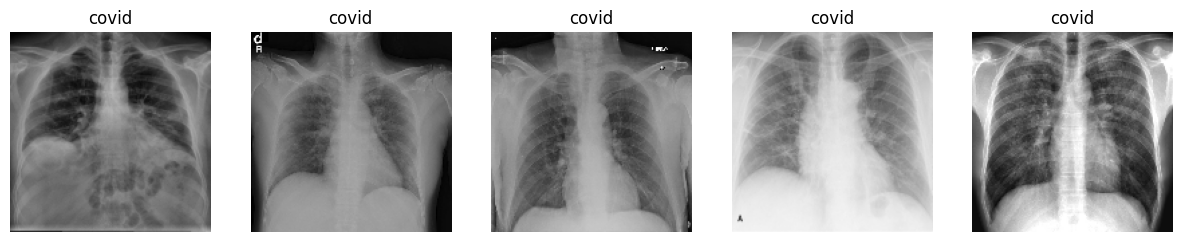

In [11]:
#Test data
plot_images (test_normal_images ,'Normal',5)
plot_images (test_covid_images ,'covid',5)


In [12]:
y_train = np.concatenate ([np.zeros (len(train_normal_images)) , np.ones (len (train_covid_images)) ])
X_train = np.concatenate ([train_normal_images,train_covid_images],axis = 0)

y_test = np.concatenate ([np.zeros (len(test_normal_images)) , np.ones (len (test_covid_images))] )
X_test = np.concatenate ([test_normal_images,test_covid_images],axis = 0)

print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)
#--------------------------------free some memory--------------------------------
train_normal_images,train_covid_images,test_normal_images,test_covid_images = None,None,None,None
del train_normal_images,train_covid_images,test_normal_images,test_covid_images 

(16000, 150, 150, 3)
(16000,)
(2166, 150, 150, 3)
(2166,)


In [13]:
train_datagen = ImageDataGenerator( rescale=1./255,
                                    rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

test_datagen = ImageDataGenerator(rescale=1./255,)

train_generator = train_datagen.flow(X_train, y_train,batch_size=16,shuffle=True)
test_generator = test_datagen.flow(X_test, y_test,batch_size=16,shuffle=False)
#--------------------------------free some memory--------------------------------
X_train,y_train,X_test = None, None,None
del X_train,y_train,X_test

In [14]:
inception = keras.applications.inception_v3.InceptionV3 (input_shape = (150,150,3),
                                                            include_top = False,
                                                            weights = 'imagenet')
inception.trainable = False   

In [30]:
last_output = inception.get_layer('mixed8').output 
x = Flatten()(last_output)
x = Dense(32, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=inception.input, outputs=x)
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights = True,verbose = 1),
             ModelCheckpoint(filepath='model.h5', monitor='val_loss', save_best_only=True)]
            
model.compile(optimizer=keras.optimizers.Adam(learning_rate=2e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_generator,epochs=10,validation_data=test_generator,callbacks=[callbacks])
model.load_weights('model.h5')

Epoch 1/10
1000/1000 [==============================] - 907s 896ms/step - loss: 0.0959 - accuracy: 0.9666 - val_loss: 0.0396 - val_accuracy: 0.9875
Epoch 2/10
1000/1000 [==============================] - 878s 878ms/step - loss: 0.0642 - accuracy: 0.9787 - val_loss: 0.0263 - val_accuracy: 0.9926
Epoch 3/10
1000/1000 [==============================] - 877s 877ms/step - loss: 0.0584 - accuracy: 0.9801 - val_loss: 0.0432 - val_accuracy: 0.9838
Epoch 4/10
1000/1000 [==============================] - 878s 878ms/step - loss: 0.0565 - accuracy: 0.9808 - val_loss: 0.0252 - val_accuracy: 0.9945
Epoch 5/10
1000/1000 [==============================] - 875s 875ms/step - loss: 0.0535 - accuracy: 0.9829 - val_loss: 0.0188 - val_accuracy: 0.9954
Epoch 6/10
1000/1000 [==============================] - 878s 878ms/step - loss: 0.0484 - accuracy: 0.9827 - val_loss: 0.0179 - val_accuracy: 0.9945
Epoch 7/10
1000/1000 [==============================] - 877s 877ms/step - loss: 0.0466 - accuracy: 0.9841 - val_

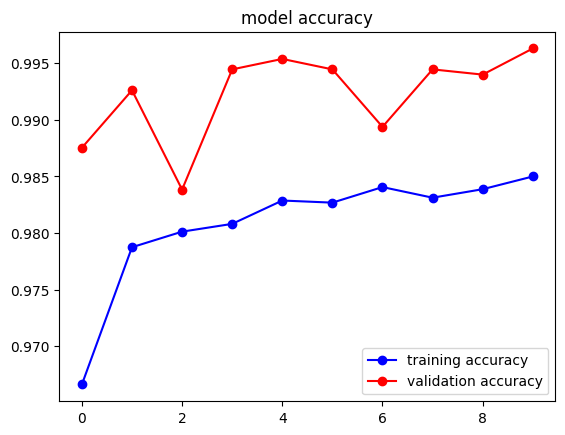

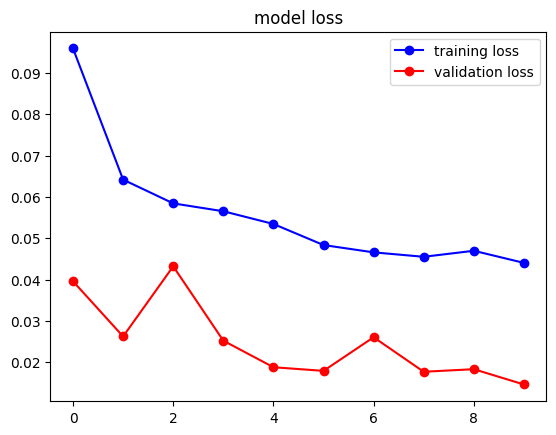

In [35]:
train_loss = history.history['loss']
val_loss = history.history['val_loss'] 
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range (len (train_acc)),train_acc,c='b',marker='o',label = 'training accuracy')
plt.plot (range (len (val_acc)),val_acc,c='r',marker='o',label = 'validation accuracy')
plt.title ('model accuracy')
plt.legend()
plt.show()

plt.plot(range (len (train_loss)),train_loss,c='b',marker='o',label = 'training loss')
plt.plot (range (len (val_loss)),val_loss,c='r',marker='o',label = 'validation loss')
plt.title ('model loss')
plt.legend()
plt.show()

In [32]:
y_pred = model.predict (test_generator)
y_pred = y_pred.reshape (-1,)
y_pred = np.float16(y_pred>=0.5 )

136/136 [==============================] - 101s 720ms/step


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1600
         1.0       0.99      0.99      0.99       566

    accuracy                           1.00      2166
   macro avg       1.00      0.99      1.00      2166
weighted avg       1.00      1.00      1.00      2166



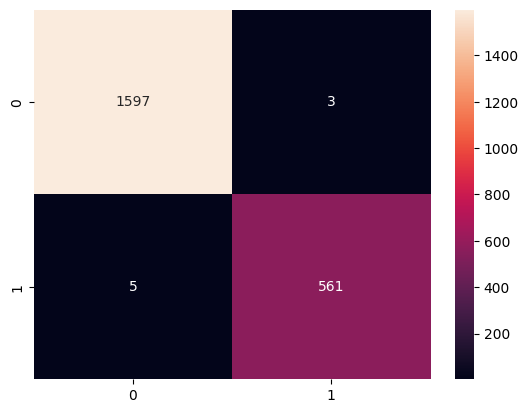

In [33]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot = True,fmt='d')
print (classification_report (y_test,y_pred))